In [ ]:
# pip install pandas matplotlib seaborn librosa wordcloud

In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import numpy as np
from wordcloud import WordCloud
from google.colab import drive

In [5]:
import warnings
# Ignore the specific warning about PySoundFile/Audioread
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [6]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/deep-learning'

In [ ]:
MELD_CSV_PATH = os.path.join(BASE_PATH, 'train_sent_emo.csv')
ECAC_JSON_PATH = os.path.join(BASE_PATH, 'Subtask_2_train.json')
AUDIO_FOLDER = os.path.join(BASE_PATH, 'train_splits')

In [ ]:
plt.style.use('ggplot')
sns.set_palette("husl")

print("Loading Data...")

Loading Data...


In [ ]:
df_text = pd.read_csv(MELD_CSV_PATH)
print(f"Text Data Loaded: {len(df_text)} utterances")

Text Data Loaded: 9989 utterances


In [ ]:
with open(ECAC_JSON_PATH, 'r') as f:
    data_cause = json.load(f)
print(f"Cause Data Loaded: {len(data_cause)} conversations")

Cause Data Loaded: 1374 conversations


In [ ]:
cause_pairs = []

for conv_data in data_cause:
    if isinstance(conv_data, dict):
        conv_id = conv_data.get('conversation_ID')

        if 'emotion-cause_pairs' in conv_data and isinstance(conv_data['emotion-cause_pairs'], list):
            for pair_str_list in conv_data['emotion-cause_pairs']:
                if len(pair_str_list) == 2:
                    try:

                        emotion_utterance_key = pair_str_list[0]
                        cause_utterance_key = pair_str_list[1]

                        emo_id = int(emotion_utterance_key.split('_')[0].replace('utt', ''))
                        cause_id = int(cause_utterance_key.split('_')[0].replace('utt', ''))

                        # To get 'emotion_type', we need to check the 'conversation' list within the current conversation data
                        emotion_type = 'unknown' # Default placeholder if not found
                        if 'conversation' in conv_data and isinstance(conv_data['conversation'], list):
                            for utterance_data in conv_data['conversation']:
                                # Assuming utterance_ID is part of the utterance_data dict
                                if utterance_data.get('utterance_ID') == emo_id:
                                    emotion_type = utterance_data.get('emotion', 'unknown')
                                    break

                        pair_data = {
                            'conv_id': conv_id,
                            'emotion_type': emotion_type,
                            'distance': emo_id - cause_id, # Positive means cause happened BEFORE emotion
                            'emotion_id': emo_id,
                            'cause_id': cause_id
                        }
                        cause_pairs.append(pair_data)
                    except (ValueError, IndexError, KeyError):
                        # Silently skip malformed entries, but could add logging for debugging
                        continue

In [ ]:
df_cause = pd.DataFrame(cause_pairs)

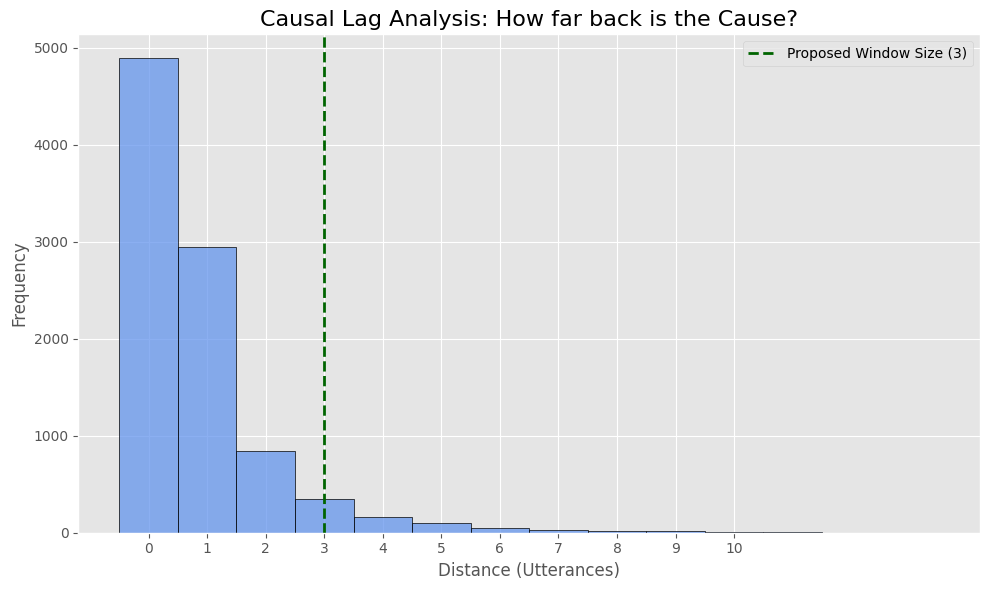

Avg Distance: 0.72 turns


In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(
    df_cause['distance'],
    bins=np.arange(0, 15) - 0.5,
    kde=False,
    color='cornflowerblue',
    edgecolor='black'
)

plt.title('Causal Lag Analysis: How far back is the Cause?', fontsize=16)
plt.xlabel('Distance (Utterances)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(0, 11))
plt.axvline(x=3, color='darkgreen', linestyle='--', linewidth=2,
            label='Proposed Window Size (3)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Avg Distance: {df_cause['distance'].mean():.2f} turns")


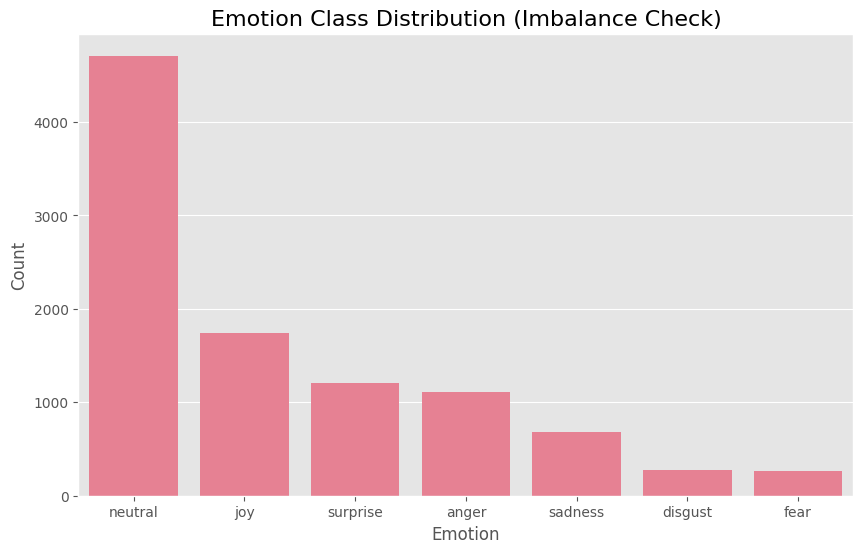

In [ ]:
plt.figure(figsize=(10, 6))
order = df_text['Emotion'].value_counts().index
sns.countplot(data=df_text, x='Emotion', order=order)
plt.title('Emotion Class Distribution (Imbalance Check)', fontsize=16)
plt.ylabel('Count')
plt.show()

In [ ]:
text_anger = " ".join(df_text[df_text['Emotion'] == 'anger']['Utterance'].astype(str))
wc = WordCloud(width=800, height=400, background_color='white').generate(text_anger)

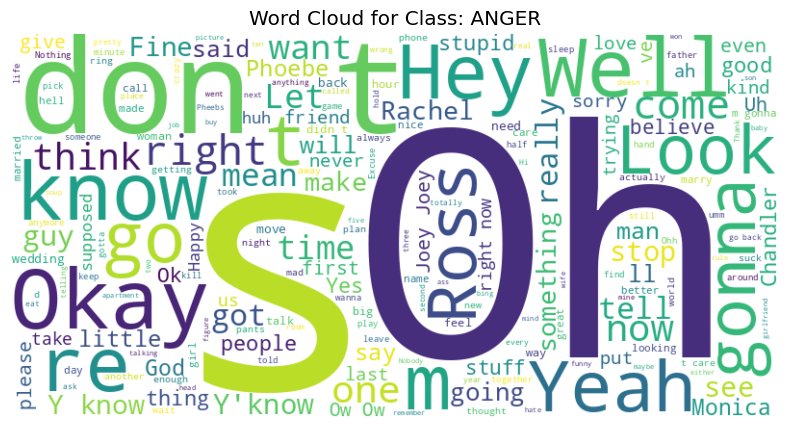

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Class: ANGER')
plt.show()

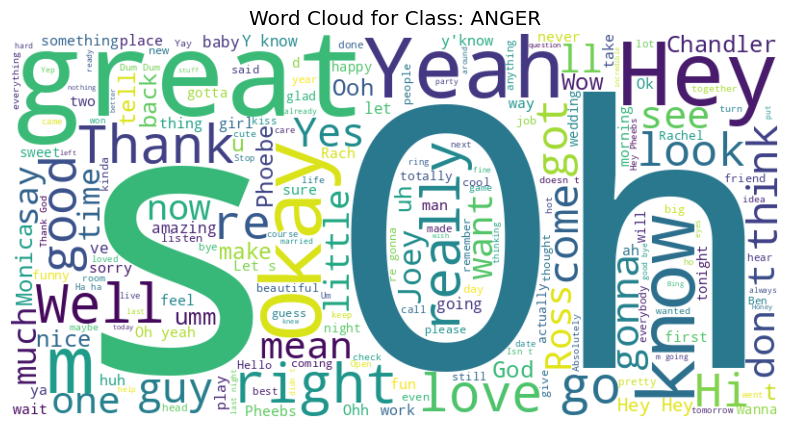

In [ ]:
text_joy = " ".join(df_text[df_text['Emotion'] == 'joy']['Utterance'].astype(str))
wc = WordCloud(width=800, height=400, background_color='white').generate(text_joy)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Class: ANGER')
plt.show()

In [ ]:
audio_durations = []
missing_files = 0

check_limit = 200
counter = 0

print(f"Checking Audio/Video files in {AUDIO_FOLDER}...")

Checking Audio/Video files in /content/drive/MyDrive/deep-learning/train_splits...


In [ ]:
# # 1. Install FFmpeg (The tool that reads MP4 audio)
# !apt-get install -y ffmpeg

# # 2. Update libraries to ensure compatibility
# !pip install librosa soundfile --upgrade

In [ ]:
# for index, row in df_text.iterrows():
#     if counter >= check_limit: break

#     filename = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.mp4"
#     filepath = os.path.join(AUDIO_FOLDER, filename)

#     if os.path.exists(filepath):
#         try:

#             dur = librosa.get_duration(path=filepath)
#             audio_durations.append({'Emotion': row['Emotion'], 'Duration': dur})
#             counter += 1
#         except Exception as e:

#             pass
#     else:
#         missing_files += 1

In [ ]:
# if len(audio_durations) > 0:
#     df_audio = pd.DataFrame(audio_durations)

#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='Emotion', y='Duration', data=df_audio)
#     plt.title('Audio Clip Duration Distribution by Emotion')
#     plt.ylabel('Duration (Seconds)')
#     plt.show()

#     print(f"Analyzed {len(df_audio)} audio files.")
# else:
#     print("Skipped Audio Plot: No audio files found in the specified path.")

# print(f"EDA Complete.")

In [ ]:

# import numpy as np
# from tqdm import tqdm

# # We will analyze a random sample to save time (processing 13,000 files takes too long)
# # Let's take 50 samples from EACH emotion to see the trend
# sampled_df = df_text.groupby('Emotion').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)

# audio_energies = []

# print(f"Analyzing Audio Energy for {len(sampled_df)} samples...")

# for index, row in tqdm(sampled_df.iterrows(), total=sampled_df.shape[0]):
#     # Construct filename
#     filename = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.mp4"
#     filepath = os.path.join(AUDIO_FOLDER, filename)

#     if os.path.exists(filepath):
#         try:
#             # Load Audio (Resample to 16k is faster)
#             # We only need the first 3 seconds to get an idea of energy
#             y, sr = librosa.load(filepath, sr=16000, duration=3.0)

#             # Calculate RMS (Root Mean Square) Energy
#             rms = librosa.feature.rms(y=y)
#             avg_energy = np.mean(rms)

#             audio_energies.append({
#                 'Emotion': row['Emotion'],
#                 'Energy_RMS': avg_energy
#             })
#         except:
#             continue

# if len(audio_energies) > 0:
#     df_energy = pd.DataFrame(audio_energies)

#     plt.figure(figsize=(10, 6))
#     # Boxplot shows the median loudness and the range
#     sns.boxplot(x='Emotion', y='Energy_RMS', data=df_energy, palette='magma', order=order)
#     plt.title('Cross-Modal Correlation: Audio Energy (Loudness) vs. Emotion')
#     plt.ylabel('Average RMS Energy')
#     plt.show()

#     # Print averages to use in your report text
#     print("\nMean Energy by Emotion (Higher = Louder):")
#     print(df_energy.groupby('Emotion')['Energy_RMS'].mean().sort_values(ascending=False))
# else:
#     print("Could not analyze energy (No audio files found).")

In [ ]:
# !pip install moviepy transformers librosa torch tqdm


In [7]:


import os
import torch
import librosa
import numpy as np
import pickle
from moviepy.editor import VideoFileClip
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm
from google.colab import drive


BASE_PATH = '/content/drive/MyDrive/deep-learning'

# Input: Where your MP4 videos are
VIDEO_FOLDER = os.path.join(BASE_PATH, 'train_splits')

# Output 1: Temporary folder for WAV files (we delete these later to save space)
WAV_FOLDER = os.path.join(BASE_PATH, 'temp_wavs')
os.makedirs(WAV_FOLDER, exist_ok=True)

# Output 2: The Final Feature File (The one you need for training)
FEATURE_SAVE_PATH = os.path.join(BASE_PATH, 'audio_features.pkl')

# Device: Use GPU if available (Much faster!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# STEP 2: LOAD WAV2VEC MODEL
# ==========================================
print("Loading Wav2Vec 2.0 Model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
model.eval() # Set to evaluation mode (no training)

# ==========================================
# STEP 3: THE EXTRACTION LOOP
# ==========================================
audio_features_dict = {}
error_files = []

# Get list of MP4s
video_files = [f for f in os.listdir(VIDEO_FOLDER) if f.endswith('.mp4')]
print(f"Found {len(video_files)} video files. Starting extraction...")

for video_file in tqdm(video_files):
    video_path = os.path.join(VIDEO_FOLDER, video_file)
    wav_path = os.path.join(WAV_FOLDER, video_file.replace('.mp4', '.wav'))
    file_id = video_file.replace('.mp4', '') # e.g., "dia0_utt0"

    try:
        # A. CONVERT MP4 -> WAV
        # We only do this if the wav doesn't exist yet (in case you restart the script)
        if not os.path.exists(wav_path):
            video = VideoFileClip(video_path)
            # Write audio: 16kHz (Standard for Wav2Vec), Mono (1 channel)
            video.audio.write_audiofile(wav_path, fps=16000, nbytes=2, codec='pcm_s16le', verbose=False, logger=None)
            video.close() # Close to free memory

        # B. LOAD WAV & PREPROCESS
        # Load exactly 6 seconds. If shorter, it pads. If longer, it truncates.
        # This keeps all vectors relatively consistent.
        audio_input, sr = librosa.load(wav_path, sr=16000, duration=6.0)

        # C. EXTRACT FEATURES
        # Tokenize (Convert to Tensor)
        input_values = processor(audio_input, sampling_rate=16000, return_tensors="pt", padding="longest").input_values
        input_values = input_values.to(device)

        # Pass through Model
        with torch.no_grad():
            outputs = model(input_values)

        # D. MEAN POOLING (Crucial Step!)
        # Wav2Vec outputs [Batch, Time, 768]. We want [768] (One vector per file).
        # We average across the Time dimension.
        last_hidden_state = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_state, dim=1).squeeze().cpu().numpy()

        # Save to dictionary
        audio_features_dict[file_id] = pooled_output

        # Clean up: Delete the temp WAV file to save Drive space
        if os.path.exists(wav_path):
            os.remove(wav_path)

    except Exception as e:
        # If a file is corrupted, skip it and log error
        # print(f"Error processing {video_file}: {e}")
        error_files.append(video_file)

# ==========================================
# STEP 4: SAVE EVERYTHING
# ==========================================
print(f"\nExtraction Complete! Processed {len(audio_features_dict)} files.")
print(f"Errors: {len(error_files)}")

print(f"Saving features to {FEATURE_SAVE_PATH}...")
with open(FEATURE_SAVE_PATH, 'wb') as f:
    pickle.dump(audio_features_dict, f)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



Using device: cpu
Loading Wav2Vec 2.0 Model...


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
import pandas as pd
import pickle
import json
import os
import numpy as np

# ================= CONFIGURATION =================
# Update paths if necessary
BASE_PATH = '/content/drive/MyDrive/deep-learning'
AUDIO_PKL_PATH = os.path.join(BASE_PATH, 'audio_features.pkl')
CSV_PATH = os.path.join(BASE_PATH, 'train_sent_emo.csv')
JSON_PATH = os.path.join(BASE_PATH, 'Subtask_2_train.json')

MAX_LEN = 64  # Max words per sentence for RoBERTa
BATCH_SIZE = 32

# Emotion Mapping (String -> Integer)
EMOTION_MAP = {
    'neutral': 0, 'joy': 1, 'surprise': 2, 'anger': 3,
    'sadness': 4, 'disgust': 5, 'fear': 6
}

# ================= THE DATASET CLASS =================
class MECPEDataset(Dataset):
    def __init__(self, csv_path, json_path, audio_pkl_path, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

        # 1. Load Data
        print(f"Loading CSV...")
        self.df = pd.read_csv(csv_path)

        print(f"Loading Audio...")
        with open(audio_pkl_path, 'rb') as f:
            self.audio_data = pickle.load(f)

        print(f"Loading JSON...")
        with open(json_path, 'r') as f:
            self.cause_data = json.load(f)

        # 2. MAPPING LOGIC (Based on your JSON snippet)
        self.cause_map = {}
        mapped_count = 0

        print("Parsing Cause Pairs...")

        for conv in self.cause_data:
            # Step A: Build a Local Map for this conversation
            # We map the JSON 'utterance_ID' (e.g., 3) to the Real Key (e.g., "dia0_utt2")
            local_id_to_key = {}

            # Check if 'conversation' list exists
            if 'conversation' in conv:
                for utt in conv['conversation']:
                    try:
                        u_id = utt['utterance_ID'] # e.g., 3
                        vid_str = utt['video_name'] # "dia1utt3.mp4"

                        # PARSE VIDEO NAME TO GET REAL NUMBERS
                        # "dia1utt3.mp4" -> dia 1, utt 3
                        # Remove extension
                        clean = vid_str.replace('.mp4', '')
                        # Split by 'utt'
                        parts = clean.split('utt')
                        dia_num = int(parts[0].replace('dia', '')) # 1
                        utt_num = int(parts[1]) # 3

                        # CONVERT TO MELD FORMAT (0-based)
                        # MELD CSV starts at 0. This JSON starts at 1.
                        final_dia = dia_num - 1
                        final_utt = utt_num - 1

                        # Create the Key our CSV expects: "dia0_utt2"
                        real_key = f"dia{final_dia}_utt{final_utt}"

                        # Save mapping: JSON ID 3 -> Real Key "dia0_utt2"
                        local_id_to_key[u_id] = real_key

                    except Exception as e:
                        continue

            # Step B: Process the Pairs using the Local Map
            if 'emotion-cause_pairs' in conv:
                for pair in conv['emotion-cause_pairs']:
                    try:
                        # Pair format: ["3_surprise", "1"]
                        e_str = pair[0]
                        c_str = pair[1]

                        # Extract IDs from strings
                        e_id_json = int(e_str.split('_')[0]) # 3
                        c_id_json = int(c_str)             # 1

                        # Translate JSON IDs to Real Keys using our map
                        if e_id_json in local_id_to_key and c_id_json in local_id_to_key:
                            e_real_key = local_id_to_key[e_id_json] # "dia0_utt2"
                            c_real_key = local_id_to_key[c_id_json] # "dia0_utt0"

                            # Calculate Distance using the Real Keys
                            # We need to extract the numbers back out from the key string
                            e_idx = int(e_real_key.split('_utt')[-1])
                            c_idx = int(c_real_key.split('_utt')[-1])

                            dist = e_idx - c_idx

                            # Valid Window 0 to 5
                            if 0 <= dist <= 5:
                                self.cause_map[e_real_key] = dist
                                mapped_count += 1
                    except:
                        continue

        print(f"SUCCESS: Mapped {mapped_count} cause labels.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]

        # CSV Key Construction: "dia0_utt2"
        unique_id = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}"

        # Text
        text = str(row['Utterance'])
        inputs = self.tokenizer(text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')

        # Audio
        if unique_id in self.audio_data:
            audio_vec = torch.tensor(self.audio_data[unique_id], dtype=torch.float32)
        else:
            audio_vec = torch.zeros(768, dtype=torch.float32)

        # Labels
        emo_label = EMOTION_MAP.get(row['Emotion'].lower(), 0)

        # Cause Label (-1 for ignore)
        cause_label = self.cause_map.get(unique_id, -1)

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'audio_vec': audio_vec,
            'emotion_label': torch.tensor(emo_label, dtype=torch.long),
            'cause_label': torch.tensor(cause_label, dtype=torch.long)
        }
# ================= TEST IT =================
print("Initializing Tokenizer...")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

print("Creating Dataset...")
dataset = MECPEDataset(CSV_PATH, JSON_PATH, AUDIO_PKL_PATH, tokenizer, MAX_LEN)

# Create a small loader to test
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Grab one batch to check shapes
sample_batch = next(iter(loader))
print("\n=== DATASET CHECK PASSED ===")
print(f"Text Input Shape: {sample_batch['input_ids'].shape} (Should be [4, 64])")
print(f"Audio Input Shape: {sample_batch['audio_vec'].shape} (Should be [4, 768])")
print(f"Emotion Labels: {sample_batch['emotion_label']}")
print(f"Cause Labels (Distance): {sample_batch['cause_label']}")

Initializing Tokenizer...
Creating Dataset...
Loading CSV...
Loading Audio...
Loading JSON...
Parsing Cause Pairs...
SUCCESS: Mapped 9299 cause labels.

=== DATASET CHECK PASSED ===
Text Input Shape: torch.Size([4, 64]) (Should be [4, 64])
Audio Input Shape: torch.Size([4, 768]) (Should be [4, 768])
Emotion Labels: tensor([1, 2, 0, 0])
Cause Labels (Distance): tensor([-1, -1, -1, -1])


In [12]:
import torch
import torch.nn as nn
from transformers import RobertaModel

class DualStreamMECPE(nn.Module):
    def __init__(self, num_emotions=7, window_size=6):
        super(DualStreamMECPE, self).__init__()

        # 1. TEXT ENCODER (RoBERTa)
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        # --- FIX IS HERE ---
        # We grab the list of layers, slice the first 6, and loop through them individually
        layers_to_freeze = list(self.roberta.encoder.layer)[:6]
        for layer in layers_to_freeze:
            for param in layer.parameters():
                param.requires_grad = False
        # -------------------

        # 2. AUDIO ENCODER (Project Wav2Vec 768 -> 768)
        self.audio_fc = nn.Sequential(
            nn.Linear(768, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # 3. CROSS-MODAL ATTENTION FUSION
        # Query = Text (768), Key = Audio (768), Value = Audio (768)
        self.cross_attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.layer_norm = nn.LayerNorm(768)

        # 4. SHARED CONTEXT LAYER (Bi-Directional LSTM)
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

        # 5. OUTPUT HEADS
        # Hidden size is 256*2 = 512
        self.emotion_classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_emotions)
        )

        # Predicts "How far back is the cause?" (0 to 5)
        self.cause_classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, window_size)
        )

    def forward(self, input_ids, attention_mask, audio_vec):
        # A. TEXT STREAM
        text_out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_seq = text_out.last_hidden_state

        # B. AUDIO STREAM
        # Input: [Batch, 768] -> Make it [Batch, 1, 768] to look like a sequence
        audio_emb = self.audio_fc(audio_vec).unsqueeze(1)

        # C. FUSION (Attention)
        # Text checks Audio for cues
        attn_out, _ = self.cross_attention(query=text_seq, key=audio_emb, value=audio_emb)

        # Residual Connection + Norm
        fused_seq = self.layer_norm(text_seq + attn_out)

        # D. POOLING (Get one vector for the whole sentence)
        # We take the [CLS] token (index 0)
        pooled_features = fused_seq[:, 0, :].unsqueeze(1) # [Batch, 1, 768]

        # E. CONTEXT (LSTM)
        lstm_out, _ = self.lstm(pooled_features)
        final_feat = lstm_out[:, -1, :] # Take last step [Batch, 512]

        # F. PREDICT
        emotion_logits = self.emotion_classifier(final_feat)
        cause_logits = self.cause_classifier(final_feat)

        return emotion_logits, cause_logits

# Initialize Model to check for errors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualStreamMECPE().to(device)
print("Model Architecture Created Successfully!")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Architecture Created Successfully!


In [10]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
from collections import Counter
import torch

# ================= CONFIGURATION =================
EPOCHS = 10
LEARNING_RATE = 2e-5
BATCH_SIZE = 16

# 1. CALCULATE CLASS WEIGHTS (To fix imbalance between Lag 0 and Lag 3)
print("Calculating Class Weights...")
all_causes = []
# Scan dataset to count classes
for i in range(len(dataset)):
    c = dataset[i]['cause_label'].item()
    if c != -1:
        all_causes.append(c)

counts = Counter(all_causes)
total_valid = sum(counts.values())
num_classes = 6 # 0 to 5

class_weights = []
for i in range(num_classes):
    count = counts.get(i, 0)
    # Inverse frequency weighting
    if count > 0:
        weight = total_valid / (num_classes * count)
    else:
        weight = 1.0
    class_weights.append(weight)

# Weights to Tensor
weights_tensor = torch.tensor(class_weights).float().to(device)
print(f"Weights: {class_weights}")

# 2. SETUP LOADER & LOSS
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion_emo = nn.CrossEntropyLoss()
# Apply Weights + Ignore -1
criterion_cause = nn.CrossEntropyLoss(weight=weights_tensor, ignore_index=-1)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

print(f"Starting Final Training on {device}...")

# ================= TRAINING LOOP =================
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    correct_emo = 0
    total_emo = 0

    correct_cause = 0
    total_cause = 0

    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        # Move to GPU
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        audio_vec = batch['audio_vec'].to(device)
        label_emo = batch['emotion_label'].to(device)
        label_cause = batch['cause_label'].to(device)

        # Forward
        out_emo, out_cause = model(input_ids, mask, audio_vec)

        # Loss
        loss_e = criterion_emo(out_emo, label_emo)
        loss_c = criterion_cause(out_cause, label_cause)

        # If batch has no valid causes, ignore cause loss
        if torch.isnan(loss_c):
            loss = loss_e
        else:
            loss = (0.7 * loss_e) + (0.3 * loss_c)

        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy Tracking
        _, pred_e = torch.max(out_emo, 1)
        _, pred_c = torch.max(out_cause, 1)

        correct_emo += (pred_e == label_emo).sum().item()
        total_emo += label_emo.size(0)

        # Cause Accuracy (Valid Only)
        valid_mask = label_cause != -1
        if valid_mask.sum() > 0:
            correct_cause += (pred_c[valid_mask] == label_cause[valid_mask]).sum().item()
            total_cause += valid_mask.sum().item()

        loop.set_description(f"Epoch {epoch+1}/{EPOCHS}")
        loop.set_postfix(loss=loss.item())

    # Stats
    avg_loss = total_loss / len(train_loader)
    acc_emo = correct_emo / total_emo
    acc_cause = correct_cause / total_cause if total_cause > 0 else 0

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Avg Loss: {avg_loss:.4f}")
    print(f"  Emotion Accuracy: {acc_emo*100:.2f}%")
    print(f"  Cause Accuracy: {acc_cause*100:.2f}%")
    print("-" * 30)

print("TRAINING COMPLETE.")
torch.save(model.state_dict(), os.path.join(BASE_PATH, 'final_model.pth'))

Calculating Class Weights...
Weights: [0.22903629536921152, 0.7310252996005326, 6.535714285714286, 16.636363636363637, 34.3125, 42.23076923076923]
Starting Final Training on cpu...


Epoch 1/10:   3%|▎         | 20/625 [03:28<1:45:16, 10.44s/it, loss=1.83]


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds_emo = []
all_labels_emo = []
all_preds_cause = []
all_labels_cause = []

print("Generating Evaluation Metrics...")

with torch.no_grad():
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        audio_vec = batch['audio_vec'].to(device)
        label_emo = batch['emotion_label'].to(device)
        label_cause = batch['cause_label'].to(device)

        out_emo, out_cause = model(input_ids, mask, audio_vec)

        _, pred_e = torch.max(out_emo, 1)
        _, pred_c = torch.max(out_cause, 1)

        all_preds_emo.extend(pred_e.cpu().numpy())
        all_labels_emo.extend(label_emo.cpu().numpy())

        # Only track valid causes (not -1)
        valid_mask = label_cause != -1
        if valid_mask.sum() > 0:
            all_preds_cause.extend(pred_c[valid_mask].cpu().numpy())
            all_labels_cause.extend(label_cause[valid_mask].cpu().numpy())

# --- PLOT CONFUSION MATRIX FOR CAUSES ---
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels_cause, all_preds_cause)
# Normalize to see percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f"Lag {i}" for i in range(6)],
            yticklabels=[f"Lag {i}" for i in range(6)])
plt.title('Causal Lag Prediction (Confusion Matrix)')
plt.xlabel('Predicted Lag')
plt.ylabel('True Lag')
plt.show()

# Print Text Report
print("\n--- EMOTION REPORT ---")
print(classification_report(all_labels_emo, all_preds_emo,
                            target_names=list(EMOTION_MAP.keys())))

print("\n--- CAUSE REPORT ---")
# Use unique labels found in data to avoid errors if some Lags are missing
unique_lags = sorted(list(set(all_labels_cause)))
print(classification_report(all_labels_cause, all_preds_cause,
                            labels=unique_lags,
                            target_names=[f"Lag {i}" for i in unique_lags]))

In [ ]:
import os
import torch
import librosa
import numpy as np
import pickle
from moviepy.editor import VideoFileClip
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm
from google.colab import drive


BASE_PATH = '/content/drive/MyDrive/deep-learning'

# Input: Where your MP4 videos are
VIDEO_FOLDER = os.path.join(BASE_PATH, 'test_splits')

# Output 1: Temporary folder for WAV files (we delete these later to save space)
WAV_FOLDER = os.path.join(BASE_PATH, 'temp_wavs')
os.makedirs(WAV_FOLDER, exist_ok=True)

# Output 2: The Final Feature File (The one you need for training)
FEATURE_SAVE_PATH = os.path.join(BASE_PATH, 'audio_test.pkl')

# Device: Use GPU if available (Much faster!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# STEP 2: LOAD WAV2VEC MODEL
# ==========================================
print("Loading Wav2Vec 2.0 Model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
model.eval() # Set to evaluation mode (no training)

# ==========================================
# STEP 3: THE EXTRACTION LOOP
# ==========================================
audio_features_dict = {}
error_files = []

# Get list of MP4s
video_files = [f for f in os.listdir(VIDEO_FOLDER) if f.endswith('.mp4')]
print(f"Found {len(video_files)} video files. Starting extraction...")

for video_file in tqdm(video_files):
    video_path = os.path.join(VIDEO_FOLDER, video_file)
    wav_path = os.path.join(WAV_FOLDER, video_file.replace('.mp4', '.wav'))
    file_id = video_file.replace('.mp4', '') # e.g., "dia0_utt0"

    try:
        # A. CONVERT MP4 -> WAV
        # We only do this if the wav doesn't exist yet (in case you restart the script)
        if not os.path.exists(wav_path):
            video = VideoFileClip(video_path)
            # Write audio: 16kHz (Standard for Wav2Vec), Mono (1 channel)
            video.audio.write_audiofile(wav_path, fps=16000, nbytes=2, codec='pcm_s16le', verbose=False, logger=None)
            video.close() # Close to free memory

        # B. LOAD WAV & PREPROCESS
        # Load exactly 6 seconds. If shorter, it pads. If longer, it truncates.
        # This keeps all vectors relatively consistent.
        audio_input, sr = librosa.load(wav_path, sr=16000, duration=6.0)

        # C. EXTRACT FEATURES
        # Tokenize (Convert to Tensor)
        input_values = processor(audio_input, sampling_rate=16000, return_tensors="pt", padding="longest").input_values
        input_values = input_values.to(device)

        # Pass through Model
        with torch.no_grad():
            outputs = model(input_values)

        # D. MEAN POOLING (Crucial Step!)
        # Wav2Vec outputs [Batch, Time, 768]. We want [768] (One vector per file).
        # We average across the Time dimension.
        last_hidden_state = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_state, dim=1).squeeze().cpu().numpy()

        # Save to dictionary
        audio_features_dict[file_id] = pooled_output

        # Clean up: Delete the temp WAV file to save Drive space
        if os.path.exists(wav_path):
            os.remove(wav_path)

    except Exception as e:
        # If a file is corrupted, skip it and log error
        # print(f"Error processing {video_file}: {e}")
        error_files.append(video_file)

# ==========================================
# STEP 4: SAVE EVERYTHING
# ==========================================
print(f"\nExtraction Complete! Processed {len(audio_features_dict)} files.")
print(f"Errors: {len(error_files)}")

print(f"Saving features to {FEATURE_SAVE_PATH}...")
with open(FEATURE_SAVE_PATH, 'wb') as f:
    pickle.dump(audio_features_dict, f)

Using device: cpu
Loading Wav2Vec 2.0 Model...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 4807 video files. Starting extraction...


100%|██████████| 4807/4807 [1:19:23<00:00,  1.01it/s]



Extraction Complete! Processed 2747 files.
Errors: 2060
Saving features to /content/drive/MyDrive/deep-learning/audio_test.pkl...


### Test Data Preparation

To evaluate the model effectively and check for overfitting, we need to use a dataset that the model has not seen during training. Below, we'll define the paths for your test data and load it into a `MECPEDataset`.

In [ ]:
# # Define Test Data Paths
# TEST_CSV_PATH = os.path.join(BASE_PATH, 'test_sent_emo.csv')
# TEST_JSON_PATH = os.path.join(BASE_PATH, 'Subtask_2_test.json')
# TEST_AUDIO_PKL_PATH = os.path.join(BASE_PATH, 'audio_test.pkl') # Assuming you've extracted audio features for test as well

# # Create Test Dataset and DataLoader
# print("Creating Test Dataset...")
# test_dataset = MECPEDataset(TEST_CSV_PATH, TEST_JSON_PATH, TEST_AUDIO_PKL_PATH, tokenizer, MAX_LEN)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle test data

# print(f"Test Dataset Loaded: {len(test_dataset)} samples.")

### Model Evaluation on Test Set

Now, we'll run the trained model on the `test_loader` to get unbiased performance metrics. This will show us how well the model generalizes to new, unseen data.

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt
# import os

# # Define the path to the saved model
# MODEL_SAVE_PATH = os.path.join(BASE_PATH, 'final_model.pth')

# # Load the trained model's state dictionary
# if os.path.exists(MODEL_SAVE_PATH):
#     print(f"Loading model weights from {MODEL_SAVE_PATH}...")
#     # Ensure the model architecture is defined and on the correct device
#     # The 'model' object (DualStreamMECPE) is assumed to be already defined
#     # and moved to 'device' by previous cells.
#     model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
#     print("Model weights loaded successfully.")
# else:
#     print(f"Error: Model weights not found at {MODEL_SAVE_PATH}. Please ensure the training loop was run and saved the model.")

# model.eval() # Set model to evaluation mode

# all_preds_emo_test = []
# all_labels_emo_test = []
# all_preds_cause_test = []
# all_labels_cause_test = []

# print("Generating Evaluation Metrics on Test Set...")

# with torch.no_grad(): # Disable gradient calculations for inference
#     for batch in tqdm(test_loader):
#         input_ids = batch['input_ids'].to(device)
#         mask = batch['attention_mask'].to(device)
#         audio_vec = batch['audio_vec'].to(device)
#         label_emo = batch['emotion_label'].to(device)
#         label_cause = batch['cause_label'].to(device)

#         out_emo, out_cause = model(input_ids, mask, audio_vec)

#         _, pred_e = torch.max(out_emo, 1)
#         _, pred_c = torch.max(out_cause, 1)

#         all_preds_emo_test.extend(pred_e.cpu().numpy())
#         all_labels_emo_test.extend(label_emo.cpu().numpy())

#         # Only track valid causes (not -1)
#         valid_mask = label_cause != -1
#         if valid_mask.sum() > 0:
#             all_preds_cause_test.extend(pred_c[valid_mask].cpu().numpy())
#             all_labels_cause_test.extend(label_cause[valid_mask].cpu().numpy())

# # --- PLOT CONFUSION MATRIX FOR CAUSES (TEST SET) ---
# plt.figure(figsize=(10, 8))
# # Explicitly define all possible labels for the confusion matrix (0 to 5)
# possible_cause_labels = list(range(6))
# cm_test = confusion_matrix(all_labels_cause_test, all_preds_cause_test, labels=possible_cause_labels)
# # Normalize to see percentages
# cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# cm_norm_test = np.nan_to_num(cm_norm_test) # Replaces NaN with 0, and inf with large finite numbers

# sns.heatmap(cm_norm_test, annot=True, fmt='.2f', cmap='Blues',
#             xticklabels=[f"Lag {i}" for i in possible_cause_labels],
#             yticklabels=[f"Lag {i}" for i in possible_cause_labels])
# plt.title('Causal Lag Prediction (Test Set Confusion Matrix)')
# plt.xlabel('Predicted Lag')
# plt.ylabel('True Lag')
# plt.show()

# # Print Text Report (Test Set)
# print("\n--- EMOTION REPORT (TEST SET) ---")
# print(classification_report(all_labels_emo_test, all_preds_emo_test,
#                             target_names=list(EMOTION_MAP.keys())))

# print("\n--- CAUSE REPORT (TEST SET) ---")
# # Use unique labels found in data to avoid errors if some Lags are missing
# unique_lags_test = sorted(list(set(all_labels_cause_test)))
# print(classification_report(all_labels_cause_test, all_preds_cause_test,
#                             labels=unique_lags_test,
#                             target_names=[f"Lag {i}" for i in unique_lags_test]))